In [44]:
# https://sccoda.readthedocs.io/en/latest/getting_started.html
# pip install sccoda
# pip install tensorflow-probability
# pip install tensorflow
# pip install tf-keras

# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import arviz as az
import scanpy as sc

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd
import anndata as ad

In [24]:
# Load data
# from https://github.com/theislab/scCODA/blob/887955e5f968960e2112fdab4258a205596540ee/sccoda/datasets/haber_counts.csv#L4

cell_counts = pd.read_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/tati/git/subject-de/code/kevin/Writeup4_composition/haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

In [25]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


In [26]:
# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)

       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


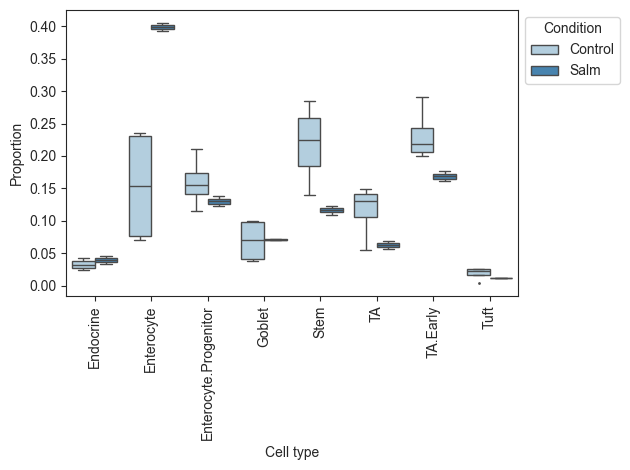

In [27]:
viz.boxplots(data_salm, feature_name="Condition")
plt.show()

In [28]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Goblet")

In [29]:
# Run MCMC
sim_results = model_salm.sample_hmc()

I0000 00:00:1711838428.691871 44367899 service.cc:145] XLA service 0x2f3a12a50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711838428.691929 44367899 service.cc:153]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2024-03-30 15:40:28.858545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711838429.175848 44367899 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [00:35<00:00, 560.56it/s]


MCMC sampling finished. (45.711 sec)
Acceptance rate: 66.5%


In [30]:
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.050        32.564898
Enterocyte                       2.325       116.540046
Enterocyte.Progenitor            2.515       140.926003
Goblet                           1.755        65.906360
Stem                             2.705       170.414713
TA                               2.099        92.966104
TA.Early                         2.857       198.390032
Tuft                             0.417        17.291844


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        23.238821   
                  Enterocyte                    1.354645       322.295725   
       

In the salmonella case, we see only a credible increase of Enterocytes, while all other cell types are unaffected by the disease. The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.

In [31]:
print(sim_results.credible_effects())

Covariate          Cell Type            
Condition[T.Salm]  Endocrine                False
                   Enterocyte                True
                   Enterocyte.Progenitor    False
                   Goblet                   False
                   Stem                     False
                   TA                       False
                   TA.Early                 False
                   Tuft                     False
Name: Final Parameter, dtype: bool


In [32]:
sim_results.set_fdr(est_fdr=0.4)
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.050        32.564898
Enterocyte                       2.325       116.540046
Enterocyte.Progenitor            2.515       140.926003
Goblet                           1.755        65.906360
Stem                             2.705       170.414713
TA                               2.099        92.966104
TA.Early                         2.857       198.390032
Tuft                             0.417        17.291844


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.414583        36.261167   
                  Enterocyte                    1.354645       332.224028   
       

A bit of a sidequest in https://sccoda.readthedocs.io/en/latest/Data_import_and_visualization.html

In [34]:
data_mouse = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_mouse.obs["Condition"] = data_mouse.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_mouse.X)
print(data_mouse.obs)

[[ 36  59 136  36 239 125 191  18]
 [  5  46  23  20  50  11  40   5]
 [ 45  98 188 124 250 155 365  33]
 [ 26 221 198  36 131 130 196   4]
 [ 42  71 203 147 271 109 180 146]
 [ 40  57 383 170 321 244 256  71]
 [ 52  75 347  66 323 263 313  51]
 [ 65 126 115  33  65  39 129  59]
 [ 37 332 113  59  90  47 132  10]
 [ 32 373 116  67 117  65 168  12]]
            Mouse     Condition
0       Control_1       Control
1       Control_2       Control
2       Control_3       Control
3       Control_4       Control
4  H.poly.Day10_1  H.poly.Day10
5  H.poly.Day10_2  H.poly.Day10
6   H.poly.Day3_1   H.poly.Day3
7   H.poly.Day3_2   H.poly.Day3
8          Salm_1          Salm
9          Salm_2          Salm


In [33]:
adata = sc.datasets.pbmc68k_reduced()
print(adata)


AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [35]:
# make three copys
adata_1 = adata.copy()
adata_1.obs["sample"] = 1

adata_2 = adata.copy()
adata_2.obs["sample"] = 2

adata_3 = adata.copy()
adata_3.obs["sample"] = 3

# join them together again
adata_all = ad.concat([adata_1, adata_2, adata_3])
print(adata_all)

AnnData object with n_obs × n_vars = 2100 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'sample'
    obsm: 'X_pca', 'X_umap'


In [36]:
# make covariate DataFrame

cov_df = pd.DataFrame({"Cond": ["A", "B", "A"]}, index=[1,2,3])
print(cov_df)

  Cond
1    A
2    B
3    A


In [37]:
data_scanpy_1 = dat.from_scanpy(
    adata_all,
    cell_type_identifier="louvain",
    sample_identifier="sample",
    covariate_df=cov_df
)
print(data_scanpy_1)

AnnData object with n_obs × n_vars = 3 × 11
    obs: 'Cond'
    var: 'n_cells'


In [38]:
data_scanpy_2 = dat.from_scanpy_list(
    [adata_1, adata_2, adata_3],
    cell_type_identifier="louvain",
    covariate_df=cov_df
)
print(data_scanpy_2)

AnnData object with n_obs × n_vars = 3 × 11
    obs: 'Cond'
    var: 'n_cells'


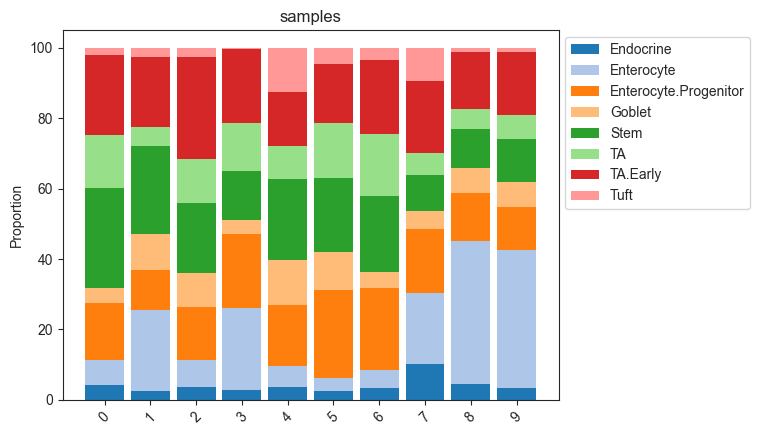

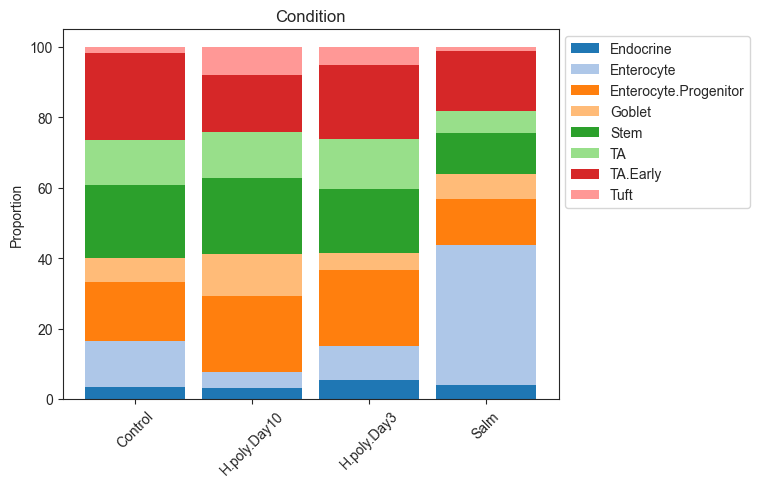

In [39]:
# Stacked barplot for each sample
viz.stacked_barplot(data_mouse, feature_name="samples")
plt.show()

# Stacked barplot for the levels of "Condition"
viz.stacked_barplot(data_mouse, feature_name="Condition")
plt.show()

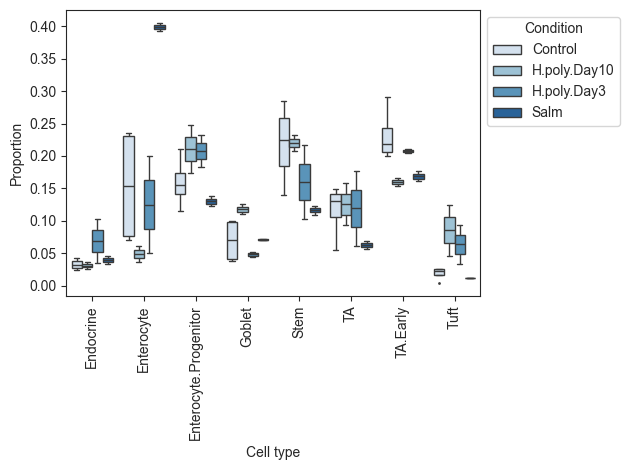

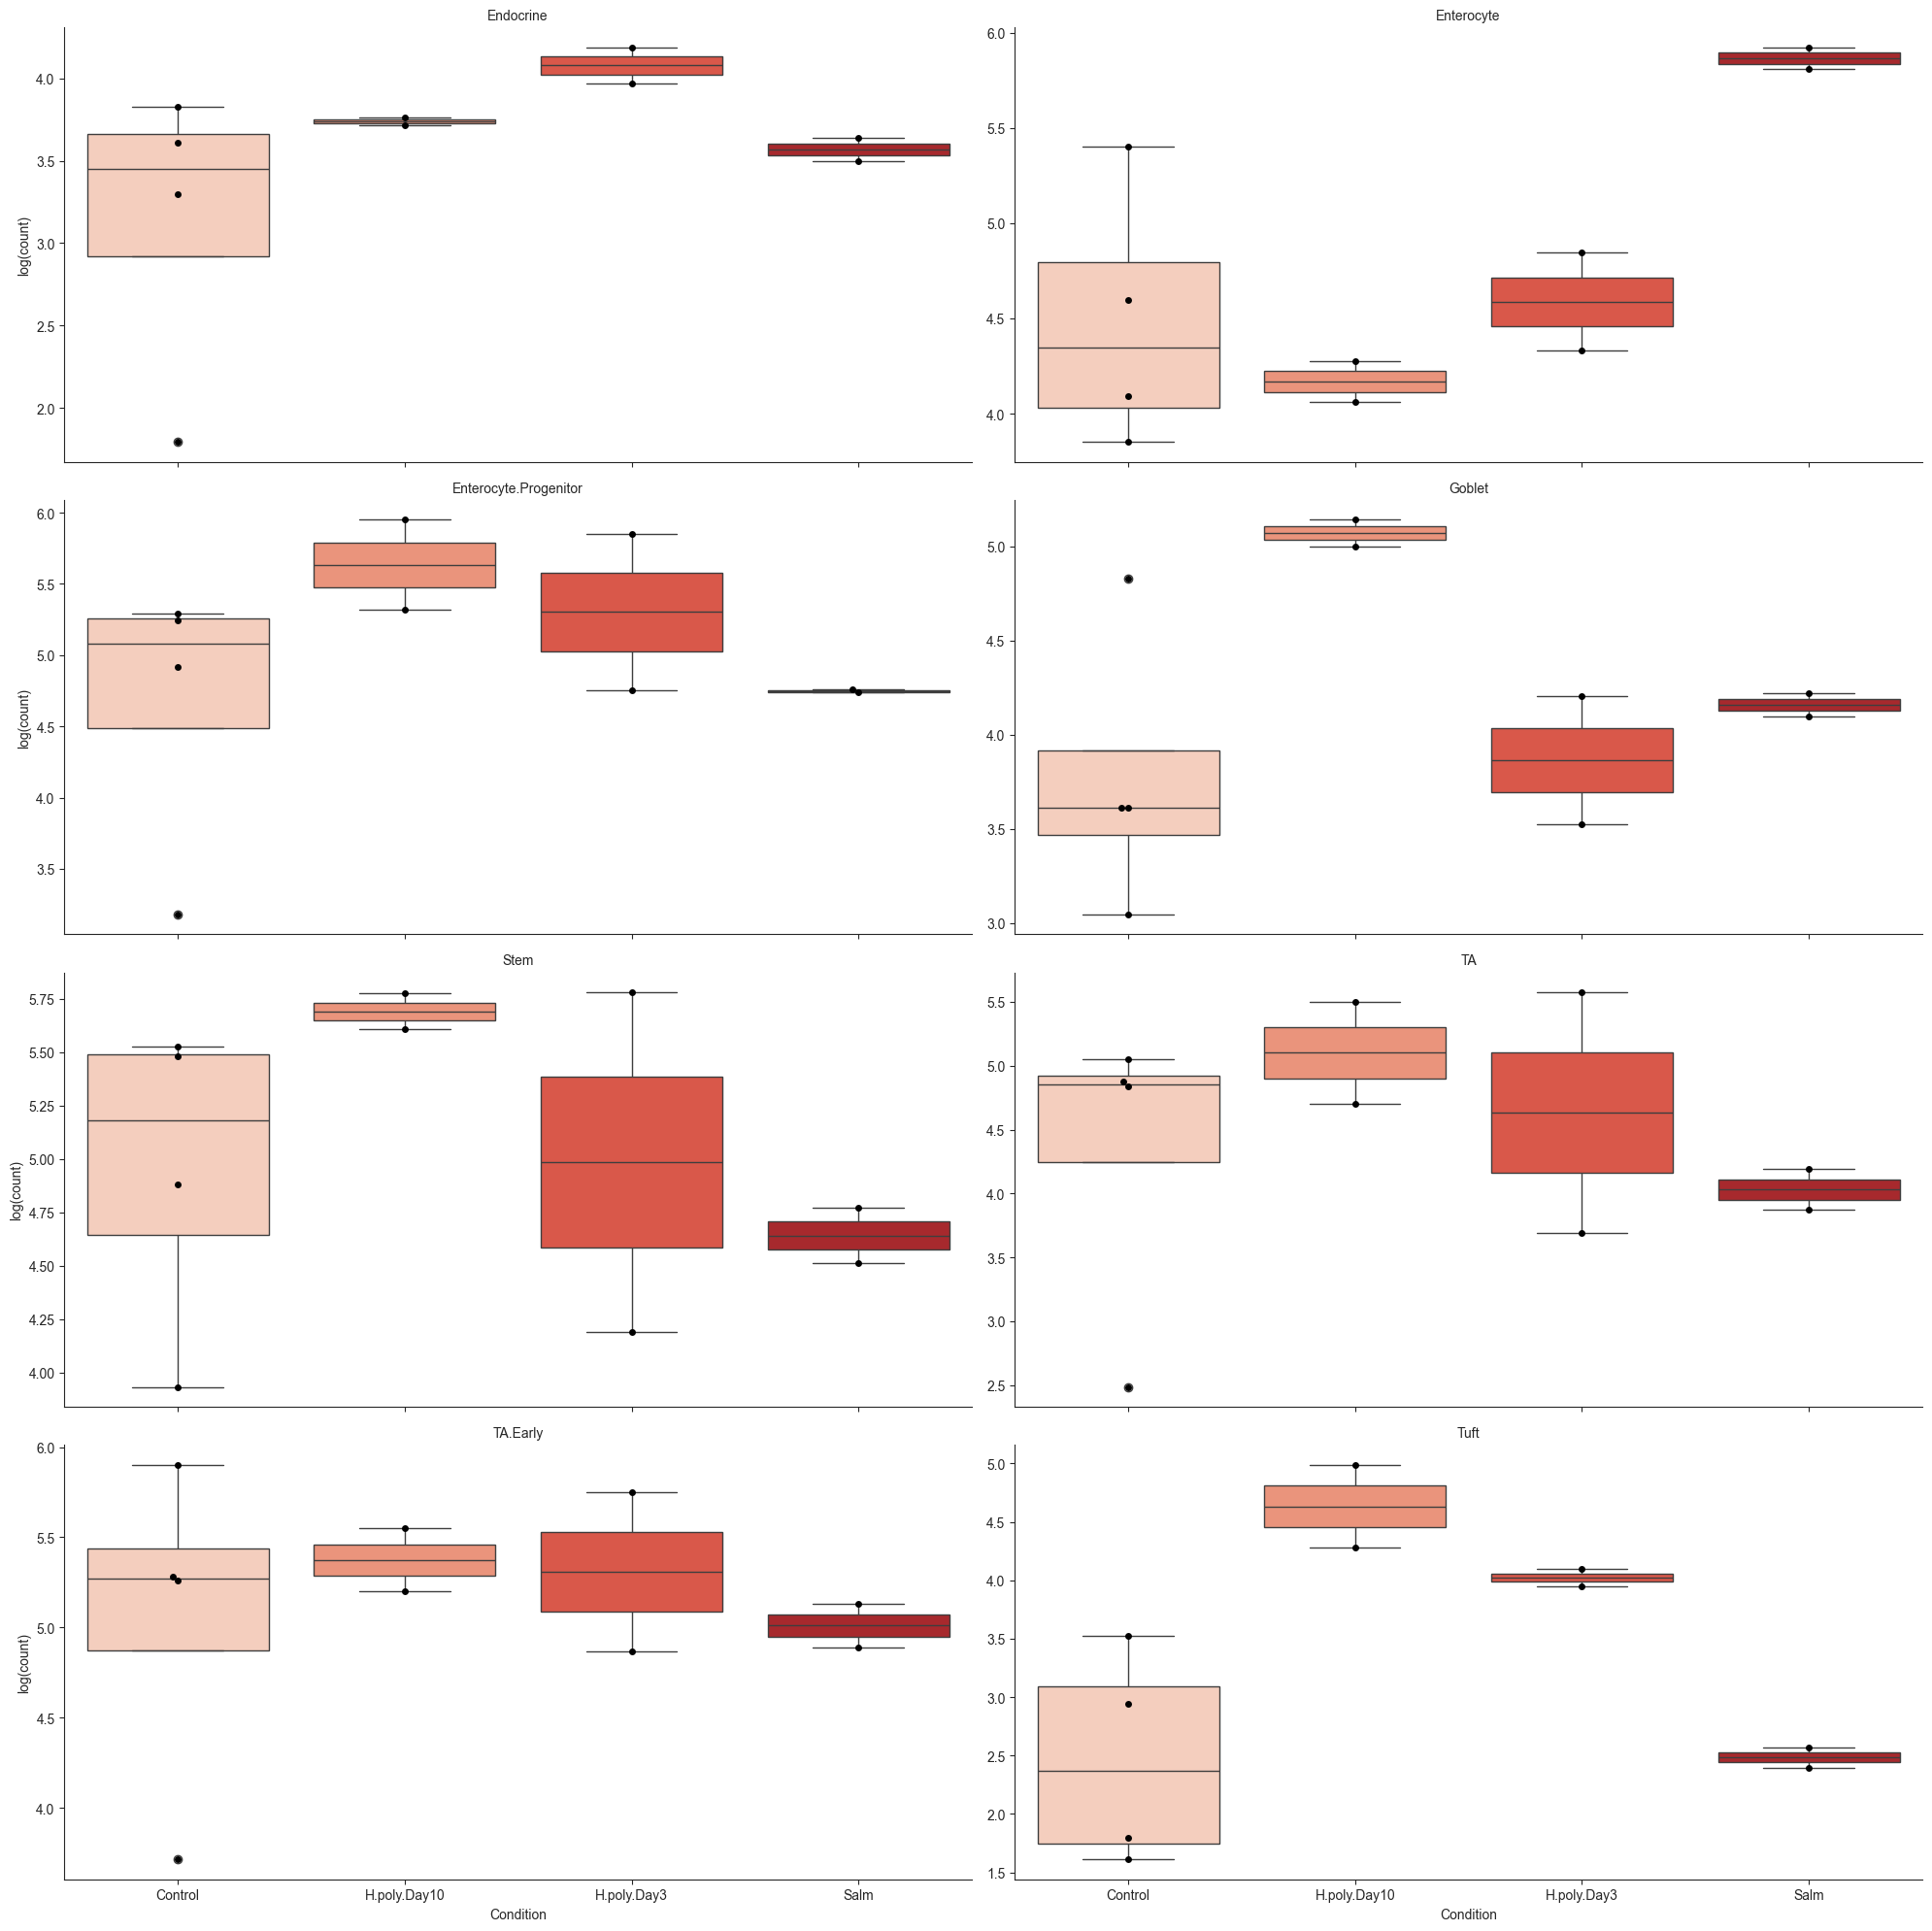

In [40]:
# Grouped boxplots. No facets, relative abundance, no dots.
viz.boxplots(
    data_mouse,
    feature_name="Condition",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
)
plt.show()

# Grouped boxplots. Facets, log scale, added dots and custom color palette.
viz.boxplots(
    data_mouse,
    feature_name="Condition",
    plot_facets=True,
    y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.show()

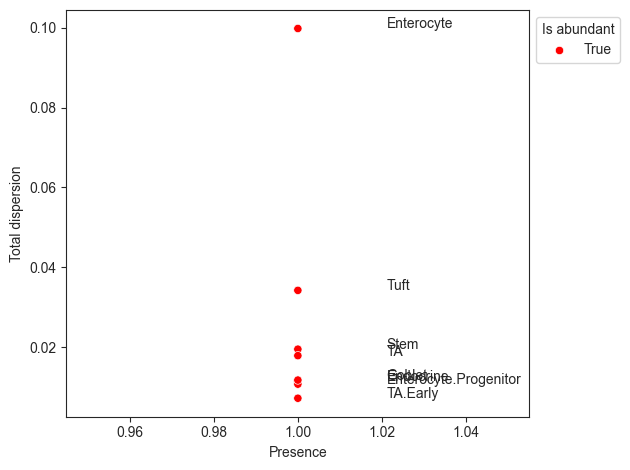

In [41]:
viz.rel_abundance_dispersion_plot(
    data=data_mouse,
    abundant_threshold=0.9
)
plt.show()

Now from https://sccoda.readthedocs.io/en/latest/Modeling_options_and_result_analysis.html

In [42]:
# model all three diseases at once
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type="Endocrine")
all_results = model_all.sample_hmc()
all_results.summary()

100%|██████████| 20000/20000 [00:36<00:00, 546.87it/s]


MCMC sampling finished. (46.752 sec)
Acceptance rate: 57.5%
Compositional Analysis summary:

Data: 10 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.969        46.882774
Enterocyte                       1.881       116.705110
Enterocyte.Progenitor            2.324       181.753309
Goblet                           1.453        76.069723
Stem                             2.402       196.497621
TA                               1.860       114.279857
TA.Early                         2.510       218.907732
Tuft                             0.621        33.103874


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte              

In [43]:
# Set salmonella infection as "default" category

model_salm_switch_cond = mod.CompositionalAnalysis(data_salm, formula="C(Condition, Treatment('Salm'))", reference_cell_type="Goblet")
switch_results = model_salm_switch_cond.sample_hmc()
switch_results.summary()

100%|██████████| 20000/20000 [00:36<00:00, 553.27it/s]


MCMC sampling finished. (45.953 sec)
Acceptance rate: 56.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: C(Condition, Treatment('Salm'))

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.215        28.441547
Enterocyte                       3.650       324.683546
Enterocyte.Progenitor            2.524       105.303958
Goblet                           1.726        47.410845
Stem                             2.582       111.592183
TA                               1.991        61.796764
TA.Early                         2.831       143.143984
Tuft                             0.403        12.627172


Effects:
                                                                  Final Parameter  \
Covariate                                  Cell Type                                
C(Condition, Treatment('Salm'))[T.Control] Endocrine           

In [45]:
model_salm_ref = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Enterocyte")
reference_results = model_salm_ref.sample_hmc()
reference_results.summary()

100%|██████████| 20000/20000 [00:36<00:00, 547.73it/s]


MCMC sampling finished. (46.582 sec)
Acceptance rate: 53.4%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 1
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.575        34.859920
Enterocyte                       2.096       159.546874
Enterocyte.Progenitor            1.882       128.809911
Goblet                           1.103        59.106314
Stem                             2.110       161.796239
TA                               1.490        87.037387
TA.Early                         2.244       184.996657
Tuft                            -0.040        18.846699


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                          0.0        34.859920   
                  Entero

In [46]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Goblet")
salm_results = model_salm.sample_hmc(num_results=20000)

100%|██████████| 20000/20000 [00:36<00:00, 555.16it/s]


MCMC sampling finished. (45.757 sec)
Acceptance rate: 50.0%


In [47]:
salm_results.summary_extended(hdi_prob=0.9)

Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 45.757 sec. Acceptance rate: 50.0%

Intercepts:
                       Final Parameter  HDI 5%  HDI 95%     SD  \
Cell Type                                                        
Endocrine                        1.123   0.585    1.752  0.364   
Enterocyte                       2.336   1.864    2.834  0.302   
Enterocyte.Progenitor            2.519   2.019    3.012  0.306   
Goblet                           1.751   1.244    2.273  0.317   
Stem                             2.709   2.237    3.193  0.297   
TA                               2.115   1.592    2.641  0.325   
TA.Early                         2.865   2.391    3.344  0.295   
Tuft                             0.443  -0.182    1.070  0.395   

                       Expected Sample  
Cell Type                             

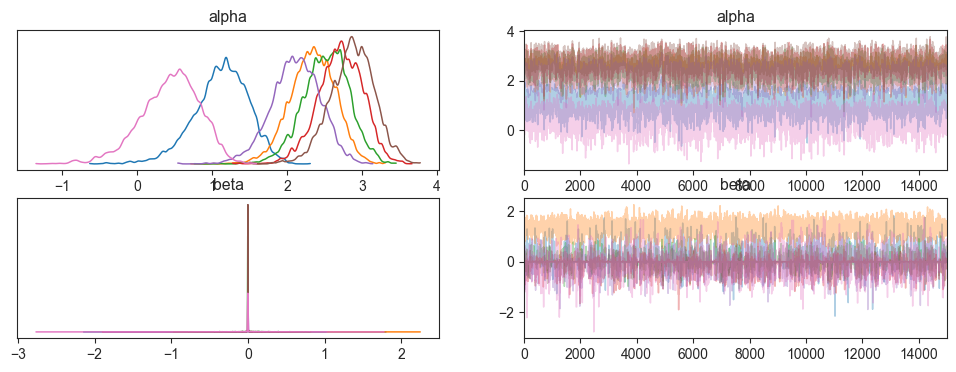

In [48]:
az.plot_trace(
    salm_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]},
)
plt.show()

In [49]:
# Run scCODA with each cell type as the reference
cell_types = data_salm.var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Endocrine


100%|██████████| 20000/20000 [00:37<00:00, 533.24it/s]


MCMC sampling finished. (47.427 sec)
Acceptance rate: 54.6%
Reference: Enterocyte


100%|██████████| 20000/20000 [00:37<00:00, 539.41it/s]


MCMC sampling finished. (46.932 sec)
Acceptance rate: 57.5%
Reference: Enterocyte.Progenitor


100%|██████████| 20000/20000 [00:37<00:00, 535.77it/s]


MCMC sampling finished. (47.207 sec)
Acceptance rate: 43.2%
Reference: Goblet


100%|██████████| 20000/20000 [00:36<00:00, 545.38it/s]


MCMC sampling finished. (46.979 sec)
Acceptance rate: 51.6%
Reference: Stem


100%|██████████| 20000/20000 [00:36<00:00, 543.19it/s]


MCMC sampling finished. (46.613 sec)
Acceptance rate: 60.6%
Reference: TA


100%|██████████| 20000/20000 [00:36<00:00, 546.06it/s]


MCMC sampling finished. (46.433 sec)
Acceptance rate: 58.3%
Reference: TA.Early


100%|██████████| 20000/20000 [00:36<00:00, 552.80it/s]


MCMC sampling finished. (45.841 sec)
Acceptance rate: 60.3%
Reference: Tuft


100%|██████████| 20000/20000 [00:36<00:00, 549.37it/s]


MCMC sampling finished. (46.321 sec)
Acceptance rate: 53.7%


In [50]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

                       times_credible  pct_credible  is_credible
Endocrine                           0         0.000        False
Enterocyte                          7         0.875         True
Enterocyte.Progenitor               0         0.000        False
Goblet                              0         0.000        False
Stem                                0         0.000        False
TA                                  0         0.000        False
TA.Early                            0         0.000        False
Tuft                                0         0.000        False
